<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [SHEEP3] - A DCGAN to Draw a Sheep, using Pytorch Lightning
<!-- DESC --> "Draw me a sheep", revisited with a DCGAN, using Pytorch Lightning
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Build and train a DCGAN model with the Quick Draw dataset
 - Understanding DCGAN

The [Quick draw dataset](https://quickdraw.withgoogle.com/data) contains about 50.000.000 drawings, made by real people...  
We are using a subset of 117.555 of Sheep drawings  
To get the dataset : [https://github.com/googlecreativelab/quickdraw-dataset](https://github.com/googlecreativelab/quickdraw-dataset)  
Datasets in numpy bitmap file : [https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap](https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap)   
Sheep dataset : [https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy](https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy) (94.3 Mo)


## What we're going to do :

 - Have a look to the dataset
 - Defining a GAN model
 - Build the model
 - Train it
 - Have a look of the results

## Step 1 - Init and parameters
#### Python init

In [1]:
import os
import sys
import shutil

import numpy as np
import torch
from lightning import Trainer
from lightning.pytorch.callbacks                        import ModelCheckpoint
from lightning.pytorch.loggers.tensorboard              import TensorBoardLogger

import fidle

from modules.QuickDrawDataModule import QuickDrawDataModule

from modules.GAN                 import GAN
from modules.WGANGP              import WGANGP
from modules.Generators          import *
from modules.Discriminators      import *

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('SHEEP3')

<br>**FIDLE - Environment initialization**

Version              : 2.3.0
Run id               : SHEEP3
Run dir              : ./run/SHEEP3
Datasets dir         : /home/pjluc/fidle-tp/datasets-fidle
Start time           : 03/03/24 14:17:52
Hostname             : Oban (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/SHEEP3/figs (True)
numpy                : 1.26.3
sklearn              : 1.4.0
yaml                 : 6.0.1
matplotlib           : 3.8.2
pandas               : 2.2.0
torch                : 2.1.2+cpu
torchvision          : 0.16.2+cpu
lightning            : 2.1.3


#### Few parameters

In [2]:
latent_dim          = 128

gan_name            = 'WGANGP'
generator_name      = 'Generator_2'
discriminator_name  = 'Discriminator_3'
    
scale               = 0.005
epochs              = 4
lr                  = 0.0001
b1                  = 0.5
b2                  = 0.999
lambda_gp           = 10
batch_size          = 64
num_img             = 48
fit_verbosity       = 2
    
dataset_file        = datasets_dir+'/QuickDraw/origine/sheep.npy' 
data_shape          = (28,28,1)

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('latent_dim', 'gan_name', 'generator_name', 'discriminator_name')  
fidle.override('epochs', 'lr', 'b1', 'b2', 'batch_size', 'num_img', 'fit_verbosity')
fidle.override('dataset_file', 'data_shape', 'scale' )

#### Cleaning

In [4]:
# You can comment these lines to keep each run...
shutil.rmtree(f'{run_dir}/figs', ignore_errors=True)
shutil.rmtree(f'{run_dir}/models', ignore_errors=True)
shutil.rmtree(f'{run_dir}/tb_logs', ignore_errors=True)

## Step 2 - Get some nice data

#### Get a Nice DataModule
Our DataModule is defined in [./modules/QuickDrawDataModule.py](./modules/QuickDrawDataModule.py)   
This is a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/data/datamodule.html)

In [5]:
dm = QuickDrawDataModule(dataset_file, scale, batch_size, num_workers=8)
dm.setup()


---- QuickDrawDataModule initialization ----------------------------
with : scale=0.005  batch size=64

DataModule Setup :
Original dataset shape :  (126121, 784)
Rescaled dataset shape :  (630, 784)
Final dataset shape    :  torch.Size([630, 28, 28, 1])
Dataset loaded and ready.


#### Have a look

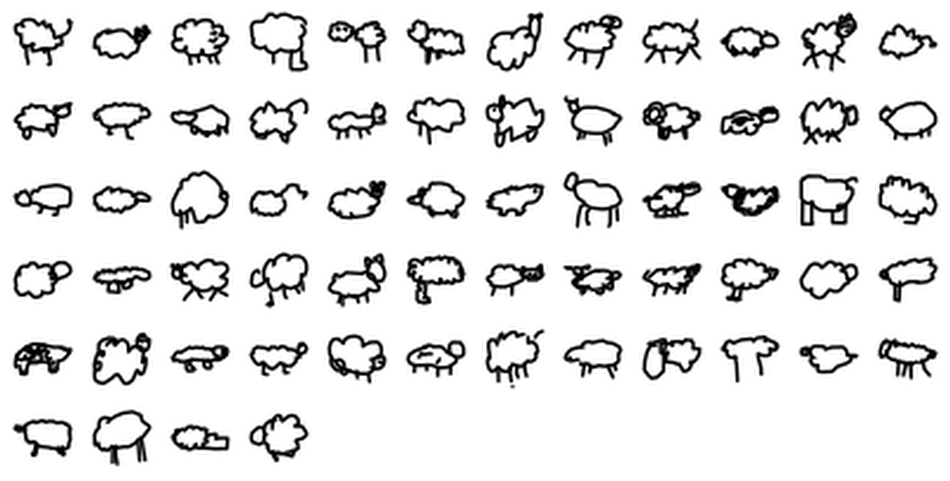

In [6]:
dl         = dm.train_dataloader()
batch_data = next(iter(dl))

fidle.scrawler.images( batch_data.reshape(-1,28,28), indices=range(batch_size), columns=12, x_size=1, y_size=1, 
                       y_padding=0,spines_alpha=0, save_as='01-Sheeps')

## Step 3 - Get a nice GAN model

Our Generators are defined in [./modules/Generators.py](./modules/Generators.py)  
Our Discriminators are defined in [./modules/Discriminators.py](./modules/Discriminators.py)  


Our GANs are defined in :
 - [./modules/GAN.py](./modules/GAN.py)  
 - [./modules/WGANGP.py](./modules/WGANGP.py)  


#### Retrieve class by name
To be very flexible, we just specify class names as parameters.  
The code below retrieves classes from their names.

In [7]:
module=sys.modules['__main__']
Generator_     = getattr(module, generator_name)
Discriminator_ = getattr(module, discriminator_name)
GAN_           = getattr(module, gan_name)

#### Basic test - Just to be sure it (could) works... ;-)

init generator 2         :  128  to  (28, 28, 1)
init discriminator 3     :  (28, 28, 1)  to sigmoid

Few tests :

z size        :  torch.Size([64, 128])
fake_img      :  torch.Size([64, 28, 28, 1])
pred fake     :  torch.Size([64, 1])
batch_data    :  torch.Size([64, 28, 28, 1])
pred real     :  torch.Size([64, 1])

Show fake images :


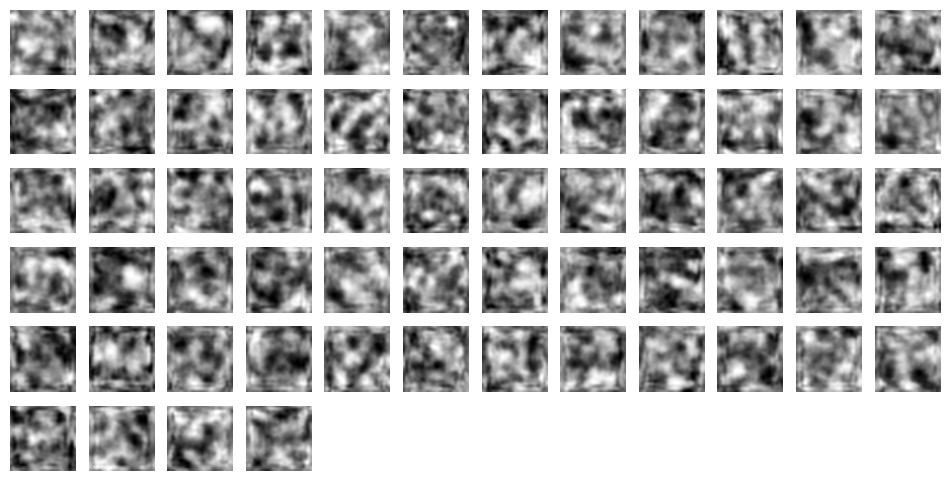

In [8]:
generator     = Generator_(     latent_dim=latent_dim, data_shape=data_shape )
discriminator = Discriminator_( latent_dim=latent_dim, data_shape=data_shape )

print('\nFew tests :\n')
z = torch.randn(batch_size, latent_dim)
print('z size        : ',z.size())

fake_img = generator.forward(z)
print('fake_img      : ', fake_img.size())

p = discriminator.forward(fake_img)
print('pred fake     : ', p.size())

print('batch_data    : ',batch_data.size())

p = discriminator.forward(batch_data)
print('pred real     : ', p.size())

print('\nShow fake images :')
nimg = fake_img.detach().numpy()
fidle.scrawler.images( nimg.reshape(-1,28,28), indices=range(batch_size), columns=12, x_size=1, y_size=1, 
                       y_padding=0,spines_alpha=0, save_as='01-Sheeps')

Fake images :  torch.Size([64, 28, 28, 1])
Batch size  :  torch.Size([64, 28, 28, 1])

interpolate images :


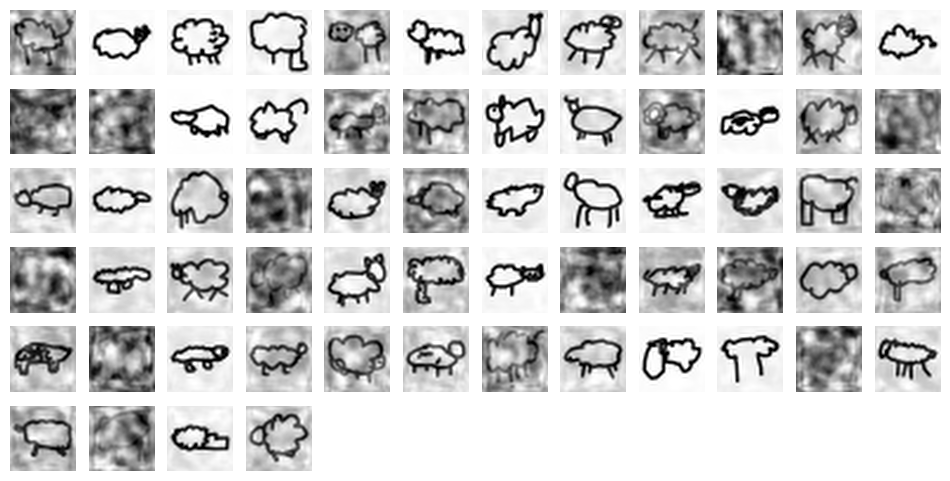

In [9]:
print('Fake images : ', fake_img.size())
print('Batch size  : ', batch_data.size())
e = torch.distributions.uniform.Uniform(0, 1).sample([batch_size,1])
e = e[:None,None,None]
i = fake_img * e + (1-e)*batch_data

print('\ninterpolate images :')
nimg = i.detach().numpy()
fidle.scrawler.images( nimg.reshape(-1,28,28), indices=range(batch_size), columns=12, x_size=1, y_size=1, 
                       y_padding=0,spines_alpha=0, save_as='01-Sheeps')


#### GAN model
To simplify our code, the GAN class is defined separately in the module [./modules/GAN.py](./modules/GAN.py)  
Passing the classe names for generator/discriminator by parameter allows to stay modular and to use the PL checkpoints.

In [10]:
gan = GAN_( data_shape          = data_shape,
            lr                  = lr,
            b1                  = b1,
            b2                  = b2,
            lambda_gp           = lambda_gp,
            batch_size          = batch_size, 
            latent_dim          = latent_dim, 
            generator_name      = generator_name, 
            discriminator_name  = discriminator_name)


---- GAN initialization --------------------------------------------
Hyperarameters are :
data_shape               : (28, 28, 1)
latent_dim               : 128
lr                       : 0.0001
b1                       : 0.5
b2                       : 0.999
batch_size               : 64
lambda_gp                : 10
generator_name           : Generator_2
discriminator_name       : Discriminator_3
Submodels :
init generator 2         :  128  to  (28, 28, 1)
init discriminator 3     :  (28, 28, 1)  to sigmoid


## Step 5 - Train it !
#### Instantiate Callbacks, Logger & co.
More about :
- [Checkpoints](https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html)
- [modelCheckpoint](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.ModelCheckpoint.html#pytorch_lightning.callbacks.ModelCheckpoint)

In [11]:

# ---- for tensorboard logs
#
logger       = TensorBoardLogger(       save_dir       = f'{run_dir}',
                                        name           = 'tb_logs'  )

log_dir = os.path.abspath(f'{run_dir}/tb_logs')
print('To access the logs with tensorboard, use this command line :')
print(f'tensorboard --logdir {log_dir}')

# ---- To save checkpoints
#
callback_checkpoints = ModelCheckpoint( dirpath        = f'{run_dir}/models', 
                                        filename       = 'bestModel', 
                                        save_top_k     = 1, 
                                        save_last      = True,
                                        every_n_epochs = 1, 
                                        monitor        = "g_loss")

To access the logs with tensorboard, use this command line :
tensorboard --logdir /home/pjluc/dev/fidle/DCGAN.Lightning/run/SHEEP3/tb_logs


#### Train it

In [12]:

trainer = Trainer(
    accelerator        = "auto",
    max_epochs         = epochs,
    callbacks          = [callback_checkpoints],
    log_every_n_steps  = batch_size,
    logger             = logger
)

trainer.fit(gan, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./run/SHEEP3/tb_logs

  | Name          | Type            | Params | In sizes | Out sizes     
------------------------------------------------------------------------------
0 | generator     | Generator_2     | 780 K  | [2, 128] | [2, 28, 28, 1]
1 | discriminator | Discriminator_3 | 401 K  | ?        | ?             
------------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.728     Total estimated model params size (MB)



DataModule Setup :
Original dataset shape :  (126121, 784)
Rescaled dataset shape :  (630, 784)
Final dataset shape    :  torch.Size([630, 28, 28, 1])
Dataset loaded and ready.


/home/pjluc/envs/fidle-env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=64). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3: 100%|██████████| 10/10 [00:14<00:00,  0.69it/s, v_num=0, g_loss=-.639, d_loss=1.070]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 10/10 [00:14<00:00,  0.67it/s, v_num=0, g_loss=-.639, d_loss=1.070]


## Step 6 - Reload our best model
Note : 

In [13]:
gan = GAN.load_from_checkpoint('./run/SHEEP3/models/bestModel.ckpt')


---- GAN initialization --------------------------------------------
Hyperarameters are :
data_shape               : (28, 28, 1)
latent_dim               : 128
lr                       : 0.0001
b1                       : 0.5
b2                       : 0.999
batch_size               : 64
generator_name           : Generator_2
discriminator_name       : Discriminator_3
lambda_gp                : 10
Submodels :
init generator 2         :  128  to  (28, 28, 1)
init discriminator 3     :  (28, 28, 1)  to sigmoid


z size        :  torch.Size([96, 128])
fake_img      :  torch.Size([96, 28, 28, 1])


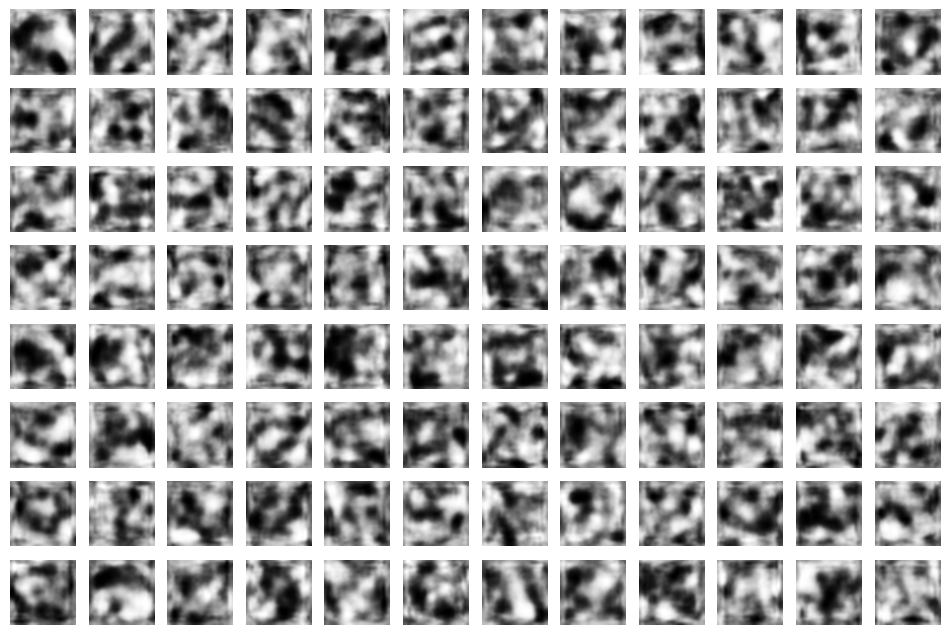

In [14]:
nb_images = 96

z = torch.randn(nb_images, latent_dim)
print('z size        : ',z.size())

fake_img = gan.generator.forward(z)
print('fake_img      : ', fake_img.size())

nimg = fake_img.detach().numpy()
fidle.scrawler.images( nimg.reshape(-1,28,28), indices=range(nb_images), columns=12, x_size=1, y_size=1, 
                       y_padding=0,spines_alpha=0, save_as='01-Sheeps')

In [15]:
fidle.end()

**End time :** 03/03/24 14:19:15  
**Duration :** 00:01:23 517ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>